In [214]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc,roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

This is the final notebook for the  logistic regression analysis. Previous iterations are in the archive folder.

In [215]:
df = pd.read_csv('/Users/tawneykirkland/GitStuff/03-mcnulty/04-data/data.csv')
df.shape

(23524, 13)

In [216]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [217]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-217-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-217-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-217-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [218]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [219]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-219-4a08e3cd5a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-219-4a08e3cd5a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [220]:
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
y_tr.drop(columns='bank_account',inplace=True)

<ipython-input-220-dc6323112d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [221]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [222]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [223]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

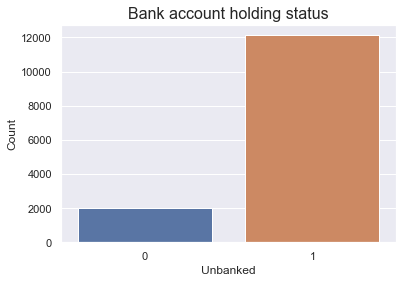

In [224]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Unbanked')
plt.ylabel('Count')
plt.show;

In [225]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", round(pct_of_no_acc*100,2))
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", round(pct_of_acc*100,2))

percentage of no account: 85.93
percentage of account 14.07


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [226]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [227]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

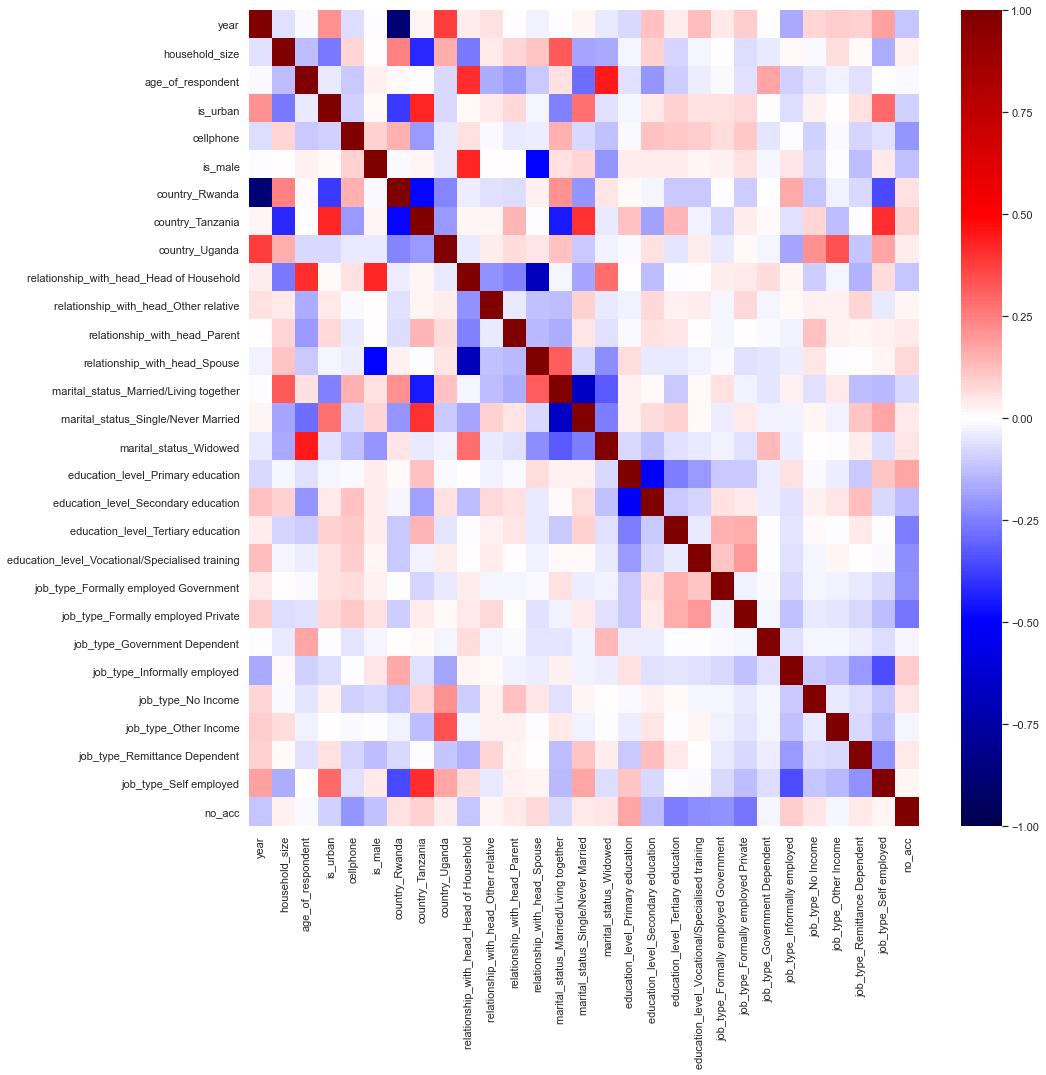

In [228]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

Note that some of these features are correlated and should be removed during analysis below

## Random Forest classifier

In [229]:
clf = RandomForestClassifier(n_estimators=100)

In [230]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [231]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train[features],y_train)

<ipython-input-231-8229e30292ca>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train[features],y_train)


RandomForestClassifier()

In [232]:
preds = clf.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(clf.score(x_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.87


In [233]:
confusion_matrix(y_val, 
                 preds)

array([[ 179,  313],
       [ 155, 2882]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 185 | 307|
| **is UNbanked (1)** | 152 | 2885 |

In [234]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.54      0.36      0.43       492
           1       0.90      0.95      0.92      3037

    accuracy                           0.87      3529
   macro avg       0.72      0.66      0.68      3529
weighted avg       0.85      0.87      0.86      3529



The model should optimise for recall given the importance of identifying the unbanked and understanding the most important features linked to being unbanked. Therefore, the recall for the positive class is quite good. However, precision is comparatively low meaning that banked individuals are being classified as unbanked. 

Precision and recall for negative class are much lower - again because many banked are being classified as unbanked

In [235]:
x_val['proba_bank'] = clf.predict_proba(x_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(y_val,
                                 x_val['proba_bank'])

<ipython-input-235-c29b7276b726>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['proba_bank'] = clf.predict_proba(x_val[features])[:, 1]


In [236]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

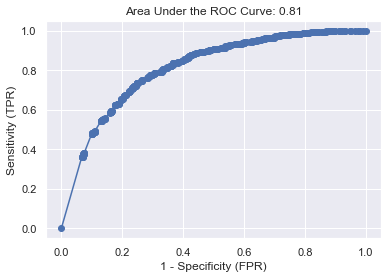

In [237]:
plot_roc(y_val, x_val['proba_bank'],fpr2,tpr2)

## Random oversampling

Dataset too small to warrant undersampling. Try ROS and then SMOTE to up sample the minority class.

In [242]:
y_train = y_train['no_acc']

In [244]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(x_train[features], y_train)

clf2 = RandomForestClassifier(n_estimators=100) 
clf2.fit(x_train[features], y_train)

print('Simple Random Forest Classifier; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, clf2.predict(x_val[features])), roc_auc_score(y_val, clf2.predict_proba(x_val[features])[:,1]))) 

clf_os = RandomForestClassifier(n_estimators=100) 
clf_os.fit(X_tr_rs, y_tr_rs)

print('Random Forest Classifier on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, clf_os.predict(x_val[features])), roc_auc_score(y_val, clf_os.predict_proba(x_val[features])[:,1])))

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (48512) in class 1 will be larger than the number of samples in the majority class (class #1 -> 12128)
  warnings.warn(


Simple Random Forest Classifier; Test F1: 0.925, Test AUC: 0.809
Random Forest Classifier on Oversampled Train Data; Test F1: 0.927, Test AUC: 0.784


In [245]:
x_val['proba_bank'] = clf_os.predict_proba(x_val[features])[:, 1]

<ipython-input-245-c3b3082bed6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['proba_bank'] = clf_os.predict_proba(x_val[features])[:, 1]


In [246]:
y_pred_ROS = np.where((x_val['proba_bank'] > 0.5),1,0)

In [247]:
print(classification_report(y_val, y_pred_ROS))

              precision    recall  f1-score   support

           0       0.55      0.31      0.40       492
           1       0.90      0.96      0.93      3037

    accuracy                           0.87      3529
   macro avg       0.73      0.63      0.66      3529
weighted avg       0.85      0.87      0.85      3529



No improvement with ROS at 50% threshold. Test moving decision threshold.

### Adjust decision threshold

In [248]:
y_pred_ROS1 = np.where((x_val['proba_bank'] > 0.75),1,0)

In [249]:
print(classification_report(y_val, y_pred_ROS1))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       492
           1       0.91      0.91      0.91      3037

    accuracy                           0.85      3529
   macro avg       0.69      0.69      0.69      3529
weighted avg       0.85      0.85      0.85      3529



Signficant improvement in prediction of minority class with some reduction in prediction of majority (positive) class.

## Adjust decision threshold only (no oversampling)

Random Forest Model best F1 score 0.934 at prob decision threshold >= 0.285


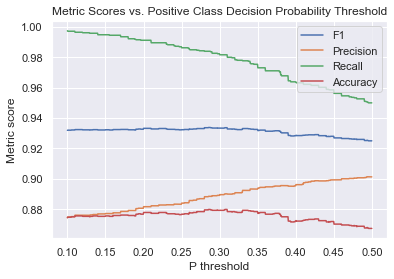

In [250]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#X_val, y_val = X_te, y_te # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = clf.predict_proba(x_val[features])[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Note that since this is for the majority class moving the threshold in this direction significantly reduces prediction for minority class

In [251]:
threshold = .56

y_pred = np.where((x_val['proba_bank'] > threshold),1,0)

In [252]:
confusion_matrix(y_val, 
                 y_pred)

array([[ 177,  315],
       [ 150, 2887]])

In [253]:
x_val['preds'] = np.where((x_val['proba_bank'] > threshold),1,0)

<ipython-input-253-3d085f866f96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['preds'] = np.where((x_val['proba_bank'] > threshold),1,0)


In [254]:
print(classification_report(y_val, x_val['preds']))

              precision    recall  f1-score   support

           0       0.54      0.36      0.43       492
           1       0.90      0.95      0.93      3037

    accuracy                           0.87      3529
   macro avg       0.72      0.66      0.68      3529
weighted avg       0.85      0.87      0.86      3529



Marginal improvement in the prediction of the minority class when compared to the logistic regression model. However, model with ROS performs better

# Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [255]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-255-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-255-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-255-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [256]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [257]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-257-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-257-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [258]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [259]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [260]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-260-41dba9f5dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Testing the model on the test sample

#### ROS model

In [261]:
preds1_test = clf_os.predict(combo_test_df[features])
print('Accuracy of Random Forest ROS classifier on test set: {:.3f}'.format(
    clf_os.score(combo_test_df[features], y_test)))

Accuracy of Random Forest ROS classifier on test set: 0.870


In [262]:
confusion_matrix(y_test, 
                 preds1_test)

array([[ 274,  560],
       [ 203, 4844]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 274 | 560|
| **is UNbanked (1)** | 203 | 4844 |

In [263]:
print(classification_report(y_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42       834
           1       0.90      0.96      0.93      5047

    accuracy                           0.87      5881
   macro avg       0.74      0.64      0.67      5881
weighted avg       0.85      0.87      0.85      5881



Note this is with 0.5 threshold. Adjusted threshold: